<a href="https://colab.research.google.com/github/DeepaliVerma/personal_files/blob/main/Video_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/Shreyz-max/Video-Captioning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/Shareddrives/Video_Captioning/new_code/

/content/drive/Shareddrives/Video_Captioning/new_code


In [3]:
#!tar -zxvf MLDS_hw2_data.tar.gz

Streaming output truncated to the last 5000 lines.
MLDS_hw2_data/training_data/video/._HPFLN5azwtA_56_63.avi
MLDS_hw2_data/training_data/video/HPFLN5azwtA_56_63.avi
MLDS_hw2_data/training_data/video/._hPyU5KjpWVc_0_35.avi
MLDS_hw2_data/training_data/video/hPyU5KjpWVc_0_35.avi
MLDS_hw2_data/training_data/video/._HqbVbPvlDoM_0_11.avi
MLDS_hw2_data/training_data/video/HqbVbPvlDoM_0_11.avi
MLDS_hw2_data/training_data/video/._hReROJQpSow_24_30.avi
MLDS_hw2_data/training_data/video/hReROJQpSow_24_30.avi
MLDS_hw2_data/training_data/video/._ht2oIYBSoI0_9_21.avi
MLDS_hw2_data/training_data/video/ht2oIYBSoI0_9_21.avi
MLDS_hw2_data/training_data/video/._htry5uxX0-Y_45_52.avi
MLDS_hw2_data/training_data/video/htry5uxX0-Y_45_52.avi
MLDS_hw2_data/training_data/video/._Hu9Sq1RvuoA_19_62.avi
MLDS_hw2_data/training_data/video/Hu9Sq1RvuoA_19_62.avi
MLDS_hw2_data/training_data/video/._HVR7KpItLfA_62_70.avi
MLDS_hw2_data/training_data/video/HVR7KpItLfA_62_70.avi
MLDS_hw2_data/training_data/video/._hW8TKz2

In [4]:
cd MLDS_hw2_data

/content/drive/Shareddrives/Video_Captioning/new_code/MLDS_hw2_data


In [5]:
!rm training_data/video/.*.avi
!rm training_data/feat/.*.npy
!rm testing_data/video/.*.avi
!rm testing_data/feat/.*.npy

In [6]:
import numpy as np
import os, sys
import pickle, functools, operator
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime


In [8]:
import tensorflow
from tensorflow.keras.utils import to_categorical

In [12]:
ls 

bleu_eval.py*                  sample_output_testset.txt  training_data/
peer_review/                   testing_data/              training_label.json*
peer_review_id.txt             testing_id.txt
sample_output_peer_review.txt  testing_label.json


In [13]:
#train_path='training_data'
TRAIN_LABEL_PATH = os.path.join('training_label.json')
# mentioning the train test split
train_split = 0.85
# loading the json file for training
with open(TRAIN_LABEL_PATH) as data_file:    
    y_data = json.load(data_file)
# train_list contains all the captions with their video ID
# vocab_list contains all the vocabulary from training data
train_list = []
vocab_list = []
for y in y_data:
  for caption in y['caption']:
    caption = "<bos> " + caption + " <eos>"
    # we are only using sentences whose length lie between 6 and 10
    if len(caption.split())>10 or len(caption.split())<6:
      continue
    else:
      train_list.append([caption, y['id']])
print(len(train_list))
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]
for train in training_list:
    vocab_list.append(train[0])
# Tokenizing the words
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)
print(len(tokenizer.word_index))
x_data = {}
TRAIN_FEATURE_DIR = os.path.join('training_data', 'feat')
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir(TRAIN_FEATURE_DIR):
    f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename))
    x_data[filename[:-4]] = f
print(len(training_list))
print(len(validation_list))
len(x_data)

17216
3983
14633
2583


1450

In [14]:
# Creating a custom data generator because we cannot load so many files at once
def load_datatest(train_path, epochs=100, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=1500,training_list=train_list, batch_size=32, maxlen=10):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)
    max_seq_length = train_sequences.shape[1]
    filesize = len(train_sequences)
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    for i in range(epochs):
      for idx in  range(0,filesize):
        n += 1
        encoder_input_data.append(x_data[videoId[idx]])
        y = to_categorical(train_sequences[idx], num_decoder_tokens)
        decoder_input_data.append(y[:-1])
        decoder_target_data.append(y[1:])
        if n == batch_size:
          encoder_input = np.array(encoder_input_data)
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0
          yield ([encoder_input, decoder_input], decoder_target)

In [15]:
# writing the train and validation generator
train = load_datatest(train_path='training_data',batch_size=320, training_list=training_list, x_data=x_data, epochs=150)
valid = load_datatest(train_path='training_data',batch_size=320, training_list=validation_list, x_data=x_data, epochs=150)

In [16]:
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=80
num_encoder_tokens=4096
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 80, 4096)]   0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 10, 1500)]   0                                            
__________________________________________________________________________________________________
endcoder_lstm (LSTM)            [(None, 80, 512), (N 9439232     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, 10, 512), (N 4122624     decoder_inputs[0][0]             
                                                                 endcoder_lstm[0][1]          

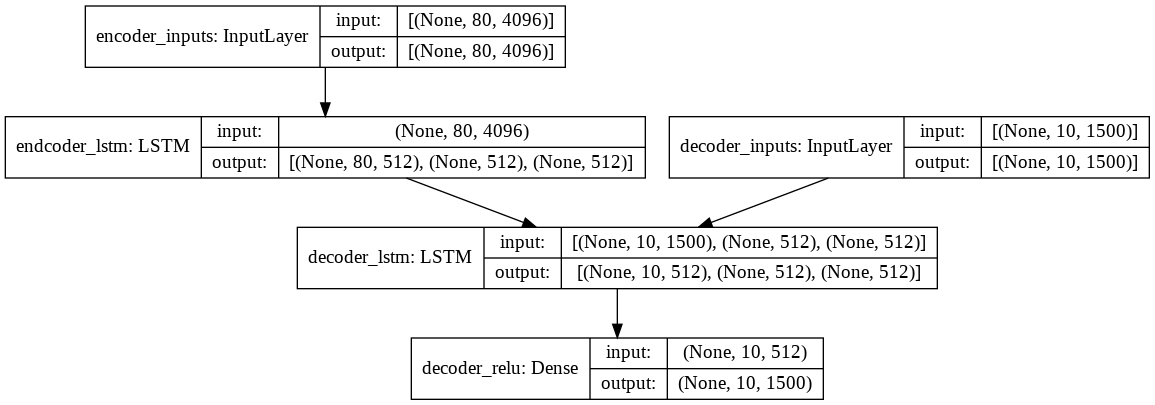

In [17]:
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading the tensorboard to visualise results
%load_ext tensorboard
import datetime
%tensorboard --logdir logs

In [ ]:
epochs=200
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = keras.optimizers.Adam(lr = 0.0003)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')


try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=epochs, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Epoch 1/200
45/45 [==============================] - 860s 19s/step - loss: 5.0423 - accuracy: 0.2812 - val_loss: 3.4105 - val_accuracy: 0.3832
Epoch 2/200
45/45 [==============================] - 830s 18s/step - loss: 3.3725 - accuracy: 0.3967 - val_loss: 3.1509 - val_accuracy: 0.4188
Epoch 3/200
23/45 [==============>...............] - ETA: 6:26 - loss: 3.1542 - accuracy: 0.4267

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss.png')
plt.show()

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy.png')
plt.show()

In [ ]:
save_model_path = 'model_final'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))
with open(os.path.join(save_model_path,'tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
# class to perform inference on all test files and save as test_output.txt
class Video2Text(object):
    ''' Initialize the parameters for the model '''
    def __init__(self):
        self.latent_dim = 512
        self.num_encoder_tokens = 4096
        self.num_decoder_tokens = 1500
        self.time_steps_encoder = 80
        self.time_steps_decoder = None
        self.preload = True
        self.preload_data_path = 'preload_data'
        self.max_probability = -1

        # processed data
        self.encoder_input_data = []
        self.decoder_input_data = []
        self.decoder_target_data = []
        self.tokenizer = None

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None
        self.save_model_path = 'model_final'
        self.test_path = 'testing_data'
    def load_inference_models(self):
        # load tokenizer
        
        with open(os.path.join(self.save_model_path, 'tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)

        # inference encoder model
        self.inf_encoder_model = load_model(os.path.join(self.save_model_path, 'encoder_model.h5'))

        # inference decoder model
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens))
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax')
        decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True)
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.inf_decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        self.inf_decoder_model.load_weights(os.path.join(self.save_model_path, 'decoder_model_weights.h5'))
    
    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value,[],[],0)
        return decode_seq

    def beam_search(self, target_seq, states_value, prob,  path, lens):
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape((self.num_decoder_tokens))
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 10
            if(sampled_char != 'eos' and lens <= MAX_LEN):
                p = output_tokens[sampled_token_index[i]]
                if(sampled_char == ''):
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens+1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if(p > self.max_probability):
                    decode_seq = path
                    self.max_probability = p

    def decoded_sentence_tuning(self, decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        unigram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in unigram:
                unigram[c] += 1
            else:
                unigram[c] = 1
            if(last_string == c and idx2 > 0):
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def get_test_data(self, path):
        X_test = []
        X_test_filename = []
        with open (os.path.join(path, 'testing_id.txt')) as testing_file:
            lines = testing_file.readlines()
            for filename in lines:
                filename = filename.strip()
                f = np.load(os.path.join(path , 'feat', filename + '.npy'))
                X_test.append(f)
                X_test_filename.append(filename[:-4])
            X_test = np.array(X_test)
        return X_test, X_test_filename

    def test(self):
        X_test, X_test_filename = self.get_test_data(os.path.join(self.test_path))
        print(len(X_test), len(X_test_filename))
        # generate inference test outputs
        with open(os.path.join(self.save_model_path, 'test_output.txt'), 'w') as file:
            for idx, x in enumerate(X_test): 
                file.write(X_test_filename[idx]+',')
                decoded_sentence = self.decode_sequence2bs(x.reshape(-1, 80, 4096))
                decode_str = self.decoded_sentence_tuning(decoded_sentence)
                for d in decode_str:
                    file.write(d + ' ')
                file.write('\n')
                # re-init max prob
                self.max_probability = -1

In [ ]:

c = Video2Text()
c.load_inference_models()
c.test()